# How to calculate bone rigidity based on CT scans?

Background: There is a technique called Computed Tomography-based Structural Rigidity Analysis (CTRA) to accurately predict and monitor fracture risk associated with metastatic lesions based on quantification of changes in bone geometry and density. For each trans-axial CT image, axial (EA) and bending (EI) rigidities for the affected bone and the contralateral (unaffected) bone are calculated by summing the modulus-weighted area of each pixel within the bone contour by the position of the pixel relative to the centroid of the bone cross-section. EA provides a measure of the bone’s resistance to uniaxial loads and EI provides a measure of the bone’s resistance to bending moments [1]. 

## Code 

The first step in each Python program is to load the required packages. Here, we take advantage of the `pydicom` to read and process the DICOM (.dcm) files. In addition to this, like so many other scientific programs, we load `numpy` and `matplotlib` packages to perform numerical computation and plotting, respectively.     

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pydicom

Then, we read the CT image file (a DICOM file) and convert it to a 2D array of numerical values. The `image` variable is a `numpy array`, which enables us to work with the pixels data of the DICOM file similar to any other matrices in MATLAB or Python.

In [2]:
scan = pydicom.read_file("I_1L/I_1L_0000.dcm")
image = scan.pixel_array

Prior to the main computation, let's have an initial look at the CT scan image using `matplotlib` to see how it looks like:

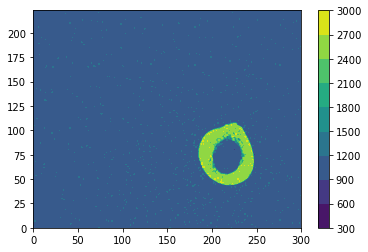

In [3]:
plt.contourf(image)
plt.colorbar()
plt.show()

Hounsfield units (HU) are a dimensionless unit used in computed tomography (CT) scanning to express CT numbers in a standardized form. By using `slopeRho` and `interceptRho` from measured data for calibrating the HU values from CT against bone mineral density (BMD), density for each pixel is calculated. 

In [4]:
slopeRho = 0.0005783
interceptRho = -0.0190450

For segmenting the bone from the background, thresholding at a threshold of 3000 HU is done. 
To prevent negative density values, a threshold is defined as `threshRho`. The transition from trabecular bone to cortical bone is assumed to occur at an apparent density of $1.1 g.cm^{-3}$. 


In [5]:
threshHU = 3000
threshRho = 0.05
trabecularValue = 1.1

The dimensions of the CT image can be read from the pixel array (`numpy` object), and the `pdicom` object can tell us the size of each pixel (`dx` and `dy`), which in turn can be used to calculate the area of each pixel (`da`). 

In [6]:
h = image.shape[0] # image height
w = image.shape[1] # image width
dx = scan.PixelSpacing[0] # width of each pixel
dy = scan.PixelSpacing[1] # height of each pixel
da = dx * dy # area of each pixel

Before looping through the pixels data, we define the required variables to be used in the loop including some empty matrices (`numpy` arrays) with the same shape of the image data. Indeed, each element of these matrices will contain the computed  variable of interest (HU, density and Young modulus) of the corresponding pixel of the image data.

In [7]:
HU = np.zeros(shape=image.shape)
rho = np.zeros(shape=image.shape)
E = np.zeros(shape=image.shape)
X = 0
Y = 0
EA = 0

To convert pixel intensity values from 0-255 in DICOM CT images to HU (-1000 to 4200) you need to use a linear transformation in terms of RescaleSlope  and RescaleIntercept (whichcan be found in the header of the DICOM image file). 
The modulus of elasticity for trabecular bone is derived using the Rice et al relationship [2]: 

\begin{equation}
E=0.82ρ+0.07 \qquad	(\text{Equation 1})
\end{equation}

and the modulus for cortical bone is derived using the Snyder et al relationship [3]:

\begin{equation}
E=21.91 ρ-23.5 \qquad	(\text{Equation 2})
\end{equation}
 
To prevent calculating E for non-zero values of density including background, the rigidity only is quantified for bone pixels (HU>0). 

Now let's dive into the main iteration over each pixel. This can be accomplished by two nested loops: 

In [8]:
for iy in range(0, h):
    for ix in range(0, w):
        HU[iy, ix] = image[iy, ix] * scan.RescaleSlope + 1024 # originally should be scan.RescaleIntercept 
        if HU[iy, ix] < threshHU: # to remove the background noise
            HU[iy, ix] = 0

        rho[iy, ix] = HU[iy, ix] * slopeRho + interceptRho # calculating the density of each pixel
        if rho[iy, ix] < threshRho: # to prevent a negative density 
            rho[iy, ix] = threshRho

        if HU[iy, ix] != 0: # otherwise E remains zero
            if rho[iy, ix] <= trabecularValue: # if the pixel belongs to a trabecular bone
                E[iy, ix] = rho[iy, ix] * 0.82 + 0.07
            else:
                E[iy, ix] = rho[iy, ix] * 21.91 - 23.5
            X += ix * dx * E[iy, ix] * da # will be used in eq. 3 
            Y += iy * dy * E[iy, ix] * da # will be used in eq. 4
            EA += E[iy, ix] * da # EA in eq. 5

The modulus neutral axis and centroid are calculated based on the coordinates of each pixel and its corresponding area (da), modulus (E), and total number of pixels in the cross section:
\begin{equation}
\bar{X}=\frac{\sum_{i=1}^n x_i E_i A_i}{\sum_{i=1}^n E_i A_i}\qquad (\text{Equation 3})
\end{equation}
\begin{equation}
\bar{Y}=\frac{\sum_{i=1}^n Y_i E_i A_i}{\sum_{i=1}^n E_i A_i}\qquad(\text{Equation 4})
\end{equation}

where x and y represent the distance of each pixel from the x and y axes, respectively.

In [9]:
centerX = X / EA
centerY = Y / EA
print(centerX)
print(centerY)

82.00433023398914
28.41906580605176


Now, it is the time to calculate the rigidity values. Firstly, we define the corresponding variables.  

In [10]:
EIX = 0
EIY = 0

EA (already calculated in the previous loop) and EI and are calculated using:  
\begin{equation}
EA=\int E(ρ)da   \qquad (\text{Equation 5})  
\end{equation}
\begin{equation}
EIX=\int E(ρ)X^2da\qquad (\text{Equation 6}) 	  
\end{equation}
\begin{equation}
EIY=\int E(ρ)Y^2da\qquad (\text{Equation 7}) 	  
\end{equation}
where x and y are the distances to the neutral axis of the trans-axial cross section, and da is the pixel area. 
The cross-section through the affected bone that had the lowest rigidity was considered the weakest link and was assumed to govern the failure behavior of the entire bone.

In [11]:
for iy in range(0, h):
    for ix in range(0, w):
        EIX += E[iy, ix] * pow((ix*dx)-centerX, 2) * da # eq. 6
        EIY += E[iy, ix] * pow((iy*dy)-centerY, 2) * da # eq. 7

Let's print the calculated rigidity values: 

In [12]:
print(f"EA = {EA}, EIX = {EIX}, EIY = {EIY}")

EA = 5274.554082053869, EIX = 245464.69795197283, EIY = 240888.3977543518


The final step is visualizing the elastic modulus map. Similarly, you can plot the density and HU maps by replacing `E` by `rho` or `HU`.

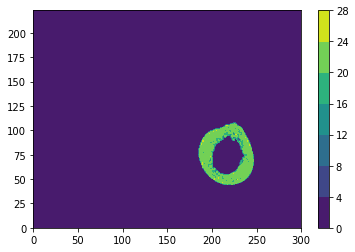

In [13]:
plt.contourf(E)
plt.colorbar()
plt.show()

## References
[1] Nazarian A, Entezari V, Zurakowski D, Calderon N, Hipp JA, Villa-Camacho JC, Lin PP, Cheung FH, Aboulafia AJ, Turcotte R,       Anderson ME. Treatment planning and fracture prediction in patients with skeletal metastasis with CT-based rigidity             analysis. Clinical Cancer Research. 2015 Jun 1;21(11):2514-9.

[2] Rice JC, Cowin SC, Bowman JA. On the dependence of the elasticity and strength of cancellous bone on apparent density.         Journal of biomechanics. 1988 Jan 1;21(2):155-68.

[3] Snyder SM, Schneider E. Estimation of mechanical properties of cortical bone by computed tomography. Journal of Orthopaedic     Research. 1991 May;9(3):422-31.
